# Master model development

## John Brandt

### Last updated: Feb 4 2019

*  Package loading
*  Hyperparameter definitions
*  Additional layer definitions
*  Model definition
*  Data loading
*  Data preprocessing
*  K means clustering
*  Augment training data
*  Loss definition
*  Equibatch creation
*  Model training
*  Model validation and sanity checks

# Experiment log
*  Baseline - Bilinear up/downsample separate for 10, 20m bands, no superresolution
*  Bilinear up/downsample for 10m bands, nearest upsample for 20m bands to 10m
*  Nearest up/downsample for all bands, no superresolution
*  Bicubic up/downsample for all bands, no superresolution
*  Bicubic up/downsample separate for 10, 20m bands, no superresolution
*  Above w/ superresolution

In [1]:
#TODO Remove imports that aren't needed to save RAM
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add, Bidirectional, ConvLSTM2D
from tensorflow.python.keras.activations import selu
from tensorflow.initializers import glorot_normal, lecun_normal

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import conv2d

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
tf.VERSION

'1.13.1'

In [2]:
%run ../src/zoneout.py
%run ../src/convgru.py
%run ../src/lovasz.py
%run ../src/utils.py
%run ../src/adabound.py
%run ../src/slope.py
%run ../src/dropblock.py

# Hyperparameter definitions

In [3]:
ZONE_OUT_PROB = 0.20
L2_REG = 0.0
INITIAL_LR = 2e-4
FINAL_LR = 1e-3
BN_MOMENTUM = 0.9
BATCH_SIZE = 16
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
MAX_DROPBLOCK = 0.85

gru_flt = 32
fpa_flt = 28
out_conv_flt = 32


AUGMENTATION_RATIO = 4
IMAGE_SIZE = 16
LABEL_SIZE = 14


# Additional layer definitions

Some of these may be able to be removed, or moved to a src/*.py

*  Conv SELU
*  Conv BN ELU
*  Feature pyramid attention (with downsample / upsample)
*  Feature pyramid attention (w/o downsample / upsample)
*  Temporal attention
*  CSE, SSE, cCSE
*  Reflection padding


In [4]:
def conv_bn_elu(inp, is_training, kernel_size, scope,
                filter_count = 16, pad = True, padding = 'valid', dilated = False,
                activation = True):
    if activation:
        act = selu
    else:
        act = None
    print(act)
    if not dilated:
        padded = ReflectionPadding2D((1, 1,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = act,
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    if not dilated and not pad:
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = act,
                        padding = padding, kernel_initializer = lecun_normal())(inp)
    if dilated:
        padded = ReflectionPadding2D((2, 2,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (3, 3), activation = act, dilation_rate = (2, 2),
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    return conv

def conv_bn_relu(inp, is_training, kernel_size, scope, filters, activation = True, use_bias = False):
    
    conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size), activation = None,
                  padding = 'valid', use_bias = use_bias,
                  kernel_initializer = tf.keras.initializers.he_normal())(inp)
    
    bn = Batch_Normalization(conv, is_training, scope)
    if activation:
        bn = tf.nn.relu(bn)

    return bn
    
def fpa(inp, is_training, filter_count):
    one = conv_bn_relu(inp, is_training, 1, 'forward1', filter_count, False)
    five = conv_bn_relu(inp, is_training, 5, 'down1', filter_count, True)
    five_f = conv_bn_relu(five, is_training, 5, 'down1_f', filter_count, False)
    three = conv_bn_relu(five, is_training, 3, 'down2', filter_count, True)
    three_f = conv_bn_relu(three, is_training, 3, 'down2_f', filter_count, False)
    
    
    three_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'bilinear')(three_f)
    #three_up = get_deconv2d(three_f, filter_count, filter_count, 'three_up', is_training)
    three_up = tf.nn.relu(three_up)
    five_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'bilinear')(five_f)
    #five_up = get_deconv2d(five_f, filter_count, filter_count, 'five_up', is_training)
    five_up = tf.nn.relu(five_up)
    
    print("One: {}".format(one.shape))
    print("Five: {}".format(five.shape))
    print("Five_F: {}".format(five_f.shape))
    print("Three: {}".format(three.shape))
    print("Three_f: {}".format(three_f.shape))
    print("Three_up: {}".format(three_up.shape))
    print("Five_up: {}".format(five_up.shape))
    
    # top block
    #pooled = tf.keras.layers.GlobalAveragePooling2D()(inp)
    #one_top = conv_bn_elu(tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
    #                      is_training, 1, 'top1', filter_count, pad = False)
    #four_top = tf.keras.layers.UpSampling2D((16, 16))(one_top)
    #rint("Sixteen top: {}".format(four_top.shape))
    
    
    concat_1 = tf.nn.relu(tf.multiply(one, tf.nn.relu(tf.add(three_up, five_up))))
    #concat_2 = tf.add(concat_1, four_top)
    print("Feature pyramid attention shape {}".format(concat_1.shape))
    return concat_1

def a2_block(inp, in_channels, c_m, c_n, k = 1):
    # c_m is the output channel number of convs for V == 1/4 in_channels
    # c_n is the output channel number of convs for A, B == 1/4 in_channels
    # implementation based on https://arxiv.org/pdf/1810.11579.pdf
    b, d, h, w, c = inp.shape[0], inp.shape[1], inp.shape[2], inp.shape[3], inp.shape[4]
    inp = tf.reshape(inp, (-1, h, w, c*d))
    #inp = tf.transpose(inp, perm = [0, 3, 1, 2])
    b, h, w, c = inp.shape[0], inp.shape[1], inp.shape[2], inp.shape[3]
    batch = inp.shape[0]
    
    A = Conv2D(filters = c_m, kernel_size = (1, 1), activation = 'linear',
                        kernel_initializer = lecun_normal(), data_format = 'channels_last')(inp)
    B = Conv2D(filters = c_n, kernel_size = (1, 1), activation = 'linear',
                        kernel_initializer = lecun_normal(), data_format = 'channels_last')(inp)
    V = Conv2D(filters = c_n, kernel_size = (1, 1), activation = 'linear',
                        kernel_initializer = lecun_normal(), data_format = 'channels_last')(inp)
    A = tf.transpose(A, perm = [0, 3, 1, 2])
    B = tf.transpose(B, perm = [0, 3, 1, 2])
    V = tf.transpose(V, perm = [0, 3, 1, 2])
    
    tmpA = tf.reshape(A, (-1, k, c_m, h*w))
    tmpA = tf.transpose(tmpA, perm=[0, 2, 1, 3])
    tmpA = tf.reshape(tmpA, (-1, c_m, k*h*w))
    
    tmpB = tf.reshape(B, (-1, k, c_n, h*w))
    tmpB = tf.transpose(tmpB, perm=[0,2,1,3])
    tmpB = tf.reshape(tmpB, (-1, c_n, k*h*w))
    
    tmpV = tf.reshape(V, (-1, k, c_n, h*w))
    tmpV = tf.transpose(tmpV, perm = [0, 1, 3, 2])
    tmpV = tf.reshape(tmpV, (inp.shape[0], c_m, h, w))
    
    softmaxB = tf.nn.softmax(tmpB)
    softmaxB = tf.reshape(softmaxB, (-1, c_n, k*h*w))
    softmaxB = tf.transpose(softmaxB, perm = [0, 2, 1])
    
    softmaxV = tf.nn.softmax(tmpV)
    softmaxV = tf.reshape(softmaxV, (-1, k*h*w, c_n))
    softmaxV = tf.transpose(softmaxV, perm = [0, 2, 1])
    
    tmpG = tf.linalg.matmul(tmpA, softmaxB)
    tmpZ = tf.linalg.matmul(tmpG, softmaxV)
    tmpZ = tf.reshape(tmpZ, (-1, c_m, k, h*w))
    tmpZ = tf.transpose(tmpV, perm = [0, 2, 1, 3])
    tmpZ = tf.reshape(tmpZ, (b, c_m, h, w))
    print(tmpZ.shape)
    
    return tmpZ
    
def create_deconv_init(filter_size, num_channels):
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x,y] = (1 - abs(x - center) / scale_factor) * \
                                   (1 - abs(y - center) / scale_factor)
    weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        weights[:, :, i, i] = bilinear_kernel

    #assign numpy array to constant_initalizer and pass to get_variable
    bilinear_init = tf.constant_initializer(value=weights, dtype=tf.float32)
    return bilinear_init



In [5]:

def get_deconv2d(inp, filter_count, num_channels, scope, is_training):
    bilinear_init = create_deconv_init(4, filter_count)
    x = tf.keras.layers.Conv2DTranspose(filters = filter_count, kernel_size = (4, 4),
                                        strides=(2, 2), padding='same', 
                                        use_bias = False,
                                        kernel_initializer = bilinear_init)(inp)
    #x = ELU()(x)
    #x = tf.nn.relu(x)
    x = Batch_Normalization(x, training=is_training, scope = scope + "bn")
    return x


def Batch_Normalization(x, training, scope):
    return batch_normalization(inputs=x, 
                               momentum = BN_MOMENTUM, 
                               training=training,
                               renorm = True,
                               reuse=None,
                               name = scope)

def temporal_attention(inp, units):
    # This rescales each output
    # Timesteps that are more important get weighted higher
    # Timesteps that are least important get weighted lower --> B, N, H, W, C
    conved = TimeDistributed(Conv2D(units, (1, 1), padding = 'same', kernel_initializer = 'glorot_uniform',
                            activation = 'tanh', strides = (1, 1)))(inp)
    
    
    #conved = tf.reshape(conved, (-1, units, 16, 16, STEPS))
    print("Attention weight shape: {}".format(conved.shape))
    conved = TimeDistributed(Conv2D(1, (1, 1), padding = 'same', kernel_initializer = 'glorot_uniform',
                            activation = 'sigmoid', use_bias = False, strides = (1, 1)))(conved)
    print("Conved sigmoid shape: {}".format(conved.shape))
    #conved = tf.reshape(conved, (-1, 24, 1, 1, 1))
    
    alphas = tf.reduce_sum(conved, axis = 1, keep_dims = True)
    print("Attention alphas: {}".format(alphas.shape))
    # We need to calculate the total sum for each pixel for each channel, so that we can combine them
    alphas = conved / alphas
    print("Attention weight shapes {}".format(alphas.shape))
    
    # This actually multiplies the Conv by the input
    multiplied = tf.reduce_sum(alphas * inp, axis = 1)
    return multiplied

In [6]:
def cse_block(prevlayer, prefix):
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer="glorot_uniform",
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''
    Implementation of Concurrent Spatial and Channel ‘Squeeze & Excitation’ in Fully Convolutional Networks
    https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    x = Add(name=prefix + "_csse_mul")([cse, sse])

    return x

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    with tf.variable_scope(scope):
        print("GRU input shape {}, zoneout: {}".format(inp.shape, ZONE_OUT_PROB))
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, fpa = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, fpa = True)
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print("Down block output shape {}".format(gru.shape))
    return gru, steps


# Model definition

## Placeholders

In [7]:
n_bands = 16
reg = keras.regularizers.l2(L2_REG) # for GRU
inp = tf.placeholder(tf.float32, shape=(None, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
length2 = tf.reshape(length, (-1,)) # Remove
is_training = tf.placeholder_with_default(False, (), 'is_training') # For BN, DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling
ft_lr = tf.placeholder_with_default(0.001, shape = ()) # For loss scheduling

## Layers

In [8]:
inp_first_half = inp[:, :, :, :, :10]
inp_second_half = inp[:, :, :, :, 11:]
no_dem = tf.concat([inp_first_half, inp_second_half], axis = -1)
dem = tf.reshape(tf.reduce_mean(inp[:, :, :, :, 10], axis = 1), (-1, 16, 16, 1))
gru_out, steps = gru_block(inp = no_dem, length = length2, 
                            size = [16, 16], 
                            flt = gru_flt, 
                            scope = 'down_16', 
                            train = is_training)

#steps_a2 = a2_block(steps, gru_flt*2, gru_flt//2, gru_flt//2, k = 1)
#print("Attention shape: {}".format(steps_a2.shape))
gru_out = tf.concat([gru_out, dem], axis = -1)
csse1 = csse_block(gru_out, 'csse1')
drop_block1 = DropBlock2D(keep_prob=keep_rate, block_size=4)
csse1 = drop_block1(csse1, is_training)

# Light FPA, CSSE, 4x4 Drop block
fpa1 = fpa(csse1, is_training, fpa_flt)
csse2 = csse_block(fpa1, 'csse2')
drop_block2 = DropBlock2D(keep_prob=keep_rate, block_size=3)
csse2 = drop_block2(csse2, is_training)


# Skip connect
x = tf.concat([csse2, csse1], axis = -1)
drop_block3 = DropBlock2D(keep_prob=keep_rate, block_size=2)
x = drop_block3(x, is_training)

x = conv_bn_elu(x, is_training, 3, "out_2", out_conv_flt, False, 'valid')
drop_block4 = DropBlock2D(keep_prob=keep_rate, block_size=1)
x = drop_block4(x, is_training)

print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
fm = Conv2D(filters = 1,
            kernel_size = (1, 1), 
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(x) # For focal loss

GRU input shape (?, 24, 16, 16, 15), zoneout: 0.2
(3, 3, 47, 64)
(1, 1, 64, 1)
(?, 16, 16, 64)
(3, 3, 47, 64)
(1, 1, 64, 1)
(?, 16, 16, 64)
Down block output shape (?, 16, 16, 64)
One: (?, 16, 16, 28)
Five: (?, 12, 12, 28)
Five_F: (?, 8, 8, 28)
Three: (?, 10, 10, 28)
Three_f: (?, 8, 8, 28)
Three_up: (?, 16, 16, 28)
Five_up: (?, 16, 16, 28)
Feature pyramid attention shape (?, 16, 16, 28)
<function selu at 0x12494fb70>
Initializing last sigmoid bias with -2.94 constant


In [9]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 221947 parameters


# Data loading

*  Load in CSV data from Collect Earth
*  Reconstruct the X, Y grid for the Y data per sample
*  Calculate NDVI, EVI, SAVI, BI, MSAVI2, and SI
*  Stack X, Y, length data
*  Apply median filter to DEM

In [10]:
data_x = np.load("../tile_data/processed/data_x_l2a_processed.npy")
data_y = np.load("../tile_data/processed/data_y_l2a_processed.npy")
lengths = np.load("../tile_data/processed/length_l2a_processed.npy")

data_x = np.delete(data_x, 14, -1) 
#data_x = np.delete(data_x, 13, -1)

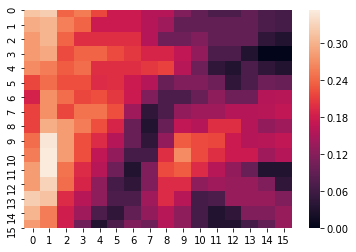

In [11]:
sns.heatmap(data_x[65, 0, :, :, 10])

In [12]:
from scipy.ndimage import median_filter
from skimage.transform import resize
for sample in tnrange(0, len(data_x)):
    filtered = median_filter(data_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    data_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
#data_x = np.delete(data_x, 10, -1)
print(data_x.shape)


(719, 24, 16, 16, 16)


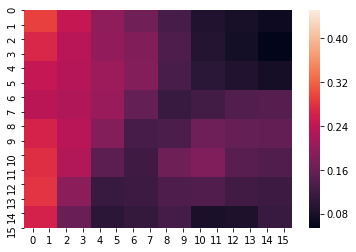

In [13]:
sns.heatmap(data_x[65, 0, :, :, 10], vmax = 0.45)

# Data preprocessing

*  Identify and remove samples with time steps / channels that have a 0. or 1. value, which indicates missing data
*  Identify and remove samples with time steps / channels with no variation, which indicates missing data
*  Identify and remove samples with values above or below the allowable values for the band
*  Identify and remove samples with null data, or samples with extreme band 0 data (which squash all the "clean" samples)
*  Smooth per-pixel temporal data with Whittaker smoother, d = 2, lambda = 0.5 to reduce sample noise

In [14]:
below_1 = [i for i, val in enumerate(data_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(data_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(data_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(data_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(data_x) if np.sum(np.isnan(val)) > 0]
oob_vals = [i for i, val in enumerate(data_x) if np.max(val[:, :, :, 0]) > 0.7]
print(oob_vals)

outliers = below_1 + above_1 + nans + oob_vals
outliers = list(set(outliers))
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)
data_x = data_x[[x for x in range(0, len(data_x)) if x not in outliers]]
data_y = data_y[[x for x in range(0, len(data_y)) if x not in outliers]]
lengths = lengths[[x for x in range(0, len(lengths)) if x not in outliers]]

[419]
The outliers are: [419], totalling 1


[] []


## Temporal Smoothing

In [15]:
high_treecover = np.argwhere(np.sum(data_y, axis = (1, 2)) < 100)
high_treecover = np.delete(data_x, high_treecover, 0)

low_treecover = np.argwhere(np.sum(data_y, axis = (1, 2)) != 0)
low_treecover = np.delete(data_x, low_treecover, 0)

high_scatter = np.std(high_treecover, axis = (0, 2, 3))
low_scatter = np.std(low_treecover, axis = (0, 2, 3))

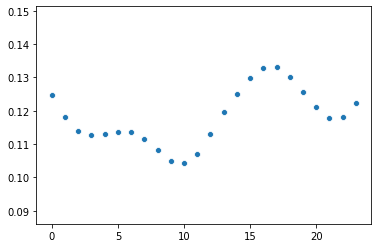

In [16]:
sns.scatterplot(y = low_scatter[:, 12], x = [x for x in range(24)])

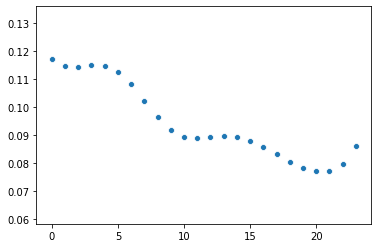

In [17]:
#y_scatter = np.mean(data_x[7, :, :, :, -4], axis = (1, 2))
sns.scatterplot(y = high_scatter[:, 12], x = [x for x in range(24)])

In [18]:
min_all = [0.020395646858960392,
 0.03833778686821461,
 0.022913980782032013,
 0.08838867269456387,
 0.05731564749032259,
 0.0796274145692587,
 0.08639285631477833,
 0.08918419919908048,
 0.07416137464344502,
 0.04398707151412964,
 0.0,
 0.008659180235117674,
 -0.0134716229327023,
 0.006902076792903247,
 0.006362500241957605,
 4.999999873689376e-05]

max_all = [0.18219037026166907,
 0.27367106080055237,
 0.3996005910634992,
 0.4859166720509528,
 0.4492199122905731,
 0.46700127094984045,
 0.49433933556079857,
 0.5116616946458816,
 0.6353135156631469,
 0.5636022371053693,
 0.3590170443058014,
 0.693415229320526,
 0.3948741647601127,
 0.6290205121040344,
 0.8152220940589849,
 0.14367499947547913]



#min_all = []
#max_all = []

for band in range(0, data_x.shape[-1]):
    print(band)
    mins1 = np.percentile(data_x[:, :, :, :, band], 1)
    maxs1 = np.percentile(data_x[:, :, :, :, band], 99)
    #mins, maxs = (np.min(data_x[:, :, :, :, band]), np.max(data_x[:, :, :, :, band]))
    mins = min_all[band]
    maxs = max_all[band]
    print(mins1 - mins, maxs1 - maxs)
    data_x[:, :, :, :, band] = np.clip(data_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (data_x[:, :, :, :, band] - midrange) / (rng / 2)
    data_x[:, :, :, :, band] = standardized
    
    #min_all.append(mins)
    #max_all.append(maxs)
    
print("The data has been scaled to [{}, {}]".format(np.min(data_x), np.max(data_x)))

0
-0.005368729280307891 -0.06255237661302096
1
-0.008936447389423847 -0.11887612372636835
2
-0.006693701781332492 -0.21150806307792647
3
-0.037311423271894455 -0.009810494780540413
4
-0.01431233756244183 -0.21646141633391386
5
-0.02889396339654924 -0.05778262108564369
6
-0.03175938200205565 -0.0008623093366624257
7
-0.0445202260836959 0.01661347448825823
8
-0.040584423504769804 -0.21344354450702663
9
-0.021325386725366113 -0.24694655060768111
10
0.0 0.0325259268283844
11
-0.04967810476198792 0.0806614100933074
12
-0.05678621901199222 -0.03172929883003239
13
-0.03664472165051848 0.07153302729129751
14
0.0034374998742714522 0.22957794904709417
15
0.0008749999433348421 0.07192499935626984
The data has been scaled to [-1.0000001192092896, 1.0000001192092896]


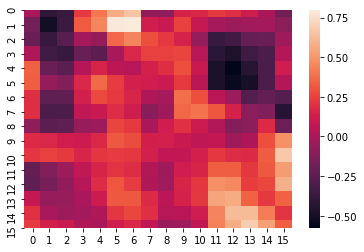

In [19]:
sns.heatmap(data_x[12, 5, :, :, 6])

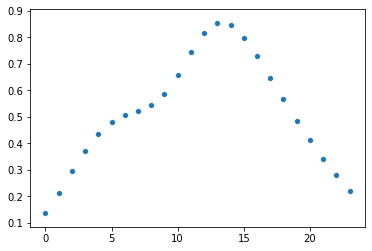

In [20]:
sns.scatterplot(y = data_x[105, :, 15, 14, 3], x = [x for x in range(24)])

# Augment training data

Horizontal and vertical flips for 4x augmentation.

**To do**
*  Random guassian noise
*  Brightness, contrast
*  Region swaps (randomply position positive samples at different locations)

In [21]:
data_x_augmented = []
data_y_augmented = []
lengths_augmented = []

for i, val in enumerate([x for x in range(len(data_x))]):
    data_x_augmented.append(data_x[val])
    data_y_augmented.append(data_y[val])
    lengths_augmented.append(data_x[val].shape[0])
    
    x1 = np.flip(data_x[val], 1)
    y1 = np.flip(data_y[val], 0)
    lengths_augmented.append(x1.shape[0])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], [2, 1])
    y1 = np.flip(data_y[val], [1, 0])
    lengths_augmented.append(x1.shape[0])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], 2)
    y1 = np.flip(data_y[val], 1)
    lengths_augmented.append(x1.shape[0])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)

train_x = np.stack(data_x_augmented)
train_y = np.stack(data_y_augmented)
train_y = np.reshape(train_y, (train_y.shape[0], 14, 14, 1))
train_l = np.stack(lengths_augmented)
train_l = np.reshape(train_l, (train_y.shape[0], 1))

In [195]:
test_x = np.load("../tile_data/processed/test_x_l2a_processed.npy")
test_y = np.load("../tile_data/processed/test_y_l2a_processed.npy")
test_lengths = np.load("../tile_data/processed/test_length_l2a_processed.npy")

test_x = np.delete(test_x, 14, -1)
#test_x = np.delete(test_x, 13, -1)


below_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(test_x) if np.sum(np.isnan(val)) > 0]
outliers = below_1 + above_1 + nans
outliers = list(set(outliers))
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)

for i in range(len(test_x)):
    mins = np.min(test_x[i, :, :, :, :])
    maxs = np.max(test_x[i, :, :, :, :])
    if mins < -1 or maxs > 1:
        offender_max = np.argmax(np.max(test_x[i, :, :, :, :], (0, 1, 2)), -1)
        offender_min = np.argmin(np.min(test_x[i, :, :, :, :], (0, 1, 2)), -1)
        
        print("{} Offender max/min: {} {}".format(i, offender_max, offender_min))
test_x = test_x[[x for x in range(0, len(test_x)) if x not in outliers]]
test_y = test_y[[x for x in range(0, len(test_y)) if x not in outliers]]
test_lengths = test_lengths[[x for x in range(0, len(test_lengths)) if x not in outliers]]

for sample in tnrange(0, len(test_x)):
    filtered = median_filter(test_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    test_x[sample, :, :, :, 10] = np.stack([filtered] * 24)

#test_x = np.delete(test_x, 10, -1)
    
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[:, :, :, :, band] = np.clip(test_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[:, :, :, :, band] - midrange) / (rng / 2)
    test_x[:, :, :, :, band] = standardized
    
    
print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))
print(test_x.shape)

The outliers are: [], totalling 0


[] []
9 Offender max/min: 14 10
14 Offender max/min: 14 10
16 Offender max/min: 14 12
21 Offender max/min: 14 10
27 Offender max/min: 14 10
29 Offender max/min: 14 10
30 Offender max/min: 14 10
32 Offender max/min: 14 12
45 Offender max/min: 14 10
51 Offender max/min: 14 10
53 Offender max/min: 14 10
60 Offender max/min: 14 10
64 Offender max/min: 14 12
69 Offender max/min: 14 11
75 Offender max/min: 14 10
85 Offender max/min: 14 10
86 Offender max/min: 14 10
118 Offender max/min: 14 10
120 Offender max/min: 14 12
122 Offender max/min: 14 12
127 Offender max/min: 14 12
129 Offender max/min: 14 12
135 Offender max/min: 14 10
136 Offender max/min: 14 10
140 Offender max/min: 14 12
141 Offender max/min: 14 12
142 Offender max/min: 14 12
145 Offender max/min: 14 10
146 Offender max/min: 14 12
149 Offender max/min: 14 12
150 Offender max/min: 14 10
151 Offender max/min: 14 12
154 Offender max/min: 14 12
157 Offender max/min: 14 12
163 Offender max/min: 14


The data has been scaled to [-1.0000001192092896, 1.0000001192092896]
(542, 24, 16, 16, 16)


In [174]:
print("Train and test characteristics:")
print("Train mean Y {}".format(np.mean([np.sum(x) for x in test_y])))
#print("Test mean Y {}".format(np.mean([np.sum(x) for x in data_y[test_ids]])))
#print("Train STD Y {}".format(np.std([np.sum(x) for x in data_y[train_ids]])))
print("Test STD Y {}".format(np.std([np.sum(x) for x in test_y])))
#print("Train number with zero trees {}".format(0.2*len([x for x in data_y[train_ids] if np.sum(x) == 0])))
#print("Test number with zero trees {}".format(0.8*len([x for x in data_y[test_ids] if np.sum(x) == 0])))
print("Train mean NDVI")
print("Test mean NDVI")
#print("There are {} train and {} test samples".format(len(train_ids), len(test_ids)))
#print("There is {} overlap between train and test".format(len([x for x in train_ids if x in test_ids])))

Train and test characteristics:
Train mean Y 56.798892988929886
Test STD Y 68.34956113977339
Train mean NDVI
Test mean NDVI


# Equibatch creation

In [24]:
sums = np.sum(train_y, axis = (1, 2))
percents = [np.percentile(sums, x) for x in range(3*10, 100, 10)]
print(percents)
print("There are {} zeros".format(len(np.argwhere(sums == 0))))

[23.0, 43.0, 67.0, 96.0, 130.0, 169.0, 196.0]
There are 304 zeros


In [25]:
train_ids = [x for x in range(0, len(train_y))]
print(len(train_ids))

def multiplot(matrices):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])
    plt.show()

print(percents)
def equibatch(train_ids, p = percents, lovasz = False):
    #percents = [7.0, 13.0, 21.0, 33.0, 50.0, 80.0, 145.0] # overall
    percents = [20.0, 40.0, 65.0, 85.0, 120.0, 155.0, 180.0] # LAC
    np.random.shuffle(train_ids)
    ix = train_ids
    percs = [np.sum(x) for x in train_y[ix]]
    ids0 = [x for x, z in zip(ix, percs) if z == 0]
    ids30 = [x for x, z in zip(ix, percs) if 0 < z < percents[0]]
    ids40 = [x for x, z in zip(ix, percs) if percents[0] < z < percents[1]]
    ids50 = [x for x, z in zip(ix, percs) if percents[1] < z < percents[2]]
    ids60 = [x for x, z in zip(ix, percs) if percents[2] < z < percents[3]]
    ids70 = [x for x, z in zip(ix, percs) if percents[3] < z < percents[4]]
    ids80 = [x for x, z in zip(ix, percs) if percents[4] < z < percents[5]]
    ids90 = [x for x, z in zip(ix, percs) if percents[5] < z < percents[6]]
    ids100 = [x for x, z in zip(ix, percs) if percents[6] < z]
    

    new_batches = []
    maxes = [len(ids0), len(ids30), len(ids40), len(ids50), len(ids60), len(ids70),
             len(ids80), len(ids90), len(ids100)]
    print(maxes)
    cur_ids = [0] * len(maxes)
    iter_len = len(train_ids)//(len(maxes)+1)
    for i in range(0, iter_len):
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 1:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 2):
            cur_ids[0] = 0
        to_append = [ids0[cur_ids[0]], ids0[cur_ids[0] + 1], ids30[cur_ids[1]], ids40[cur_ids[2]],
                    ids50[cur_ids[3]],
                    ids60[cur_ids[4]], ids70[cur_ids[5]], ids80[cur_ids[6]],
                    ids90[cur_ids[7]], ids100[cur_ids[8]]]
        
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        cur_ids[0] += 1
        
    new_batches = [item for sublist in new_batches for item in sublist]
    #overlap = [x for x in new_batches if x in test_ids]
    #print("There is {} overlap. Error if > 0".format(len(overlap)))
    return new_batches

batch = equibatch(train_ids)

2872
[23.0, 43.0, 67.0, 96.0, 130.0, 169.0, 196.0]
[304, 480, 284, 284, 232, 308, 228, 216, 464]


In [26]:
sum_pos = np.sum(train_y[batch])
sum_neg = len(train_y[batch]) * 196 - sum_pos
beta = (sum_pos + sum_neg - 1) / (sum_pos + sum_neg)
print("Beta: {}".format(beta))
samples_per_cls = np.array([sum_neg, sum_pos])
effective_num = 1.0 - np.power(beta, samples_per_cls)
weights = (1.0 - beta) / np.array(effective_num)
weights = weights / np.sum(weights)
weight = weights[1] / weights[0]
weight -= 0.25
print(weight)


Beta: 0.9999982222854299
1.1574583092407031



# Loss definition

The current best loss is a combination of weighted binary cross entropy and per-image Lovasz-Softmax, with a loss schedule with the latter becoming more important each epoch

In [27]:
from keras.losses import binary_crossentropy
import math
from scipy.ndimage import distance_transform_edt as distance

def weighted_bce_loss(y_true, y_pred, weight, mask = None, smooth = 0.025):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )
    return tf.reduce_mean(loss)

def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        if np.sum(seg) >= 30:
            sums = np.sum(seg)
            sums = 196 if sums < 146 else sums
            res[np.where(res == 1)] = (sums/196)
            res[np.where(np.isclose(res, 1.41421356, rtol = 1e-2))] = (sums/196)
        else:
            res[np.where(res == 1)] = 0.
            res[np.where(np.isclose(res, 1.41421356, rtol = 1e-2))] = 0.125
        res[np.where(res == 0)] = -1 + (np.sum(seg) / 196)
    #if np.sum(seg) <= 196//2:
    #    res[np.where(res == 1)] = 0.
    #    res[np.where(np.isclose(res, 1.41421356, rtol = 1e-2))] = 0.125
    #    res[np.where(res == 0)] = -1.
    #if np.sum(seg) > 196//2:
    #    res[np.where(res == 1)] = 0.75
     #   res[np.where(np.isclose(res, 1.41421356, rtol = 1e-2))] = 1.0
     #   res[np.where(res == 0)] = -0.5

    res[np.where(res < -1.5)] = -1.5
    res[np.where(res > 2)] = 2.
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
        res *= -1
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    max_value = np.sqrt(2*(14 - 1)**2 )
    return res# / max_value

def calc_mask_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    res[np.where(res == 0)] = 1.
    res[np.where(res == 1)] = 0.25
    res[np.where(res < 0)] = 1.
    res[np.where(res > 1)] = 1.
    return res# / max_value

def calc_dist_map_batch(y_true):
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)

def surface_loss(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    loss = K.mean(multipled)
    #loss = (loss - -2.9052) / (2.9052 - -2.9052) # max and min possible value for the loss fn
    return loss

def bce_loss(y_true, y_pred, smooth = 0.05, mask = None):
    bce = weighted_bce_loss(y_true, y_pred, 1.4, smooth)
    return bce

def finetune_loss(y_true, y_pred):
    lv = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    return lv

def surf_lovasz(y_true, y_pred, alpha):
    lv = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    surf = surface_loss(y_true, y_pred)
    return ( (1-alpha)*lv + (alpha * surf) )
    
def bce_surf(y_true, y_pred, alpha, smooth = 0.05, weight = weight, mask = None, ):
    bce =  weighted_bce_loss(y_true, y_pred, weight, smooth = smooth)
    surf = surface_loss(y_true, y_pred)
    return ( (1-alpha)*bce + (alpha * surf) )#global_loss #+ regional_loss

def bce_lv(y_true, y_pred, alpha, smooth = 0.08, mask = None, ):
    bce =  weighted_bce_loss(y_true, y_pred, 1.5, smooth = smooth)
    #surf = surface_loss(y_true, y_pred)
    lv = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    #global_loss = (1 - alpha) * ((1-alpha)*bce + alpha*lv)
    #regional_loss = alpha * surf
    #return lv
    return ( (1-alpha)*bce + (alpha * lv) )#global_loss #+ regional_loss

countries = {'africaeast': [0, 34],
             'africawest': [35, 96], 
             'cameroon': [97, 135], 
             'ethiopia': [136, 248], 
             'ghana': [249, 318],
             'india': [319, 369], 
             'kenya': [370, 458],
             'lac': [459, 541],
             'all': [0, 541]}

#! Move to a src.py
def dice_loss(y_true, y_pred):
    numerator = 2 * np.sum(y_true * y_pred, axis=-1)
    denominator = np.sum(y_true + y_pred, axis=-1)
    return (numerator + 1) / (denominator + 1)

def calculate_metrics(country, al = 0.4):
    start_idx = countries[country][0]
    stop_idx = countries[country][1]
    best_f1 = 0
    best_dice = 0
    best_thresh = 0
    hausdorff = 0
    p = 0
    r = 0
    error = 0
    d = 0
    ys = []
    vls = []
    t_alls = []
    test_ids = [x for x in range(len(test_x))]
    for test_sample in test_ids[start_idx:stop_idx]:
        y, vl = sess.run([fm, test_loss], feed_dict={inp: test_x[test_sample].reshape(1, 24, 16, 16, n_bands),
                                          length: test_lengths[test_sample].reshape(1, 1),
                                          is_training: False,
                                          labels: test_y[test_sample, :, :].reshape(1, 14, 14),
                                          alpha: al,
                                          })
        ys.append(y.reshape((14, 14)))
        vls.append(vl)
        t = test_y[test_sample].reshape((14, 14))
        t_alls.append(t)
    to_remove = np.argwhere(vls > np.percentile(vls, 98))
    if len(to_remove) >= 0:
        ys = list(np.delete(np.array(ys), to_remove, 0))
        t_alls = list(np.delete(np.array(t_alls), to_remove, 0))
    for thresh in range(7, 13):
        tps = []
        fps = []
        fns = []
        haus = []
        trues = []
        preds = []
        dice_losses = []
        val_loss = []
        for sample in range(len(ys)):
            pred = np.copy(ys[sample])
            true = t_alls[sample]
            vl = vls[sample]
            haus.append(scipy.spatial.distance.directed_hausdorff(pred, true)[0])
            pred[np.where(pred > thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            true_s = np.sum(true)
            pred_s = np.sum(pred)
            p_error = np.around(((abs(pred_s - true_s))/196), 3)
            tp, fp, fn = thirty_meter(true, pred)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            trues.append(true_s)
            preds.append(pred_s)
            if np.sum(true + pred) > 0:
                dice_losses.append(dice_loss(true.flatten(), pred.flatten()))
            if np.sum(true + pred) == 0:
                dice_losses.append(1.)
            val_loss.append(np.mean(vl))
        oa_error = abs(np.sum(preds) - np.sum(trues)) / np.sum(trues)
        precision = np.sum(tps) / (np.sum(tps) + np.sum(fps))
        recall = np.sum(tps) / (np.sum(tps) + np.sum(fns))
        f1 = 2*((precision* recall) / (precision + recall))
        haus = np.mean(haus)
        dices = np.mean(dice_losses)
        if f1 > best_f1:
            best_dice = dices
            best_f1 = f1
            p = precision
            r = recall
            error = oa_error
            best_thresh = thresh*0.05
    print("{}: Val loss: {} Thresh: {} F1: {} R: {} P: {} D: {} H: {} Error: {}".format(country, np.around(np.mean(val_loss), 3), np.around(best_thresh, 2),
                                                                                     np.around(best_f1, 3), np.around(p, 3), np.around(r, 3), 
                                                                                     np.around(best_dice, 3), np.around(haus, 3),
                                                                                     np.around(error, 3)))
    return np.mean(val_loss), best_dice

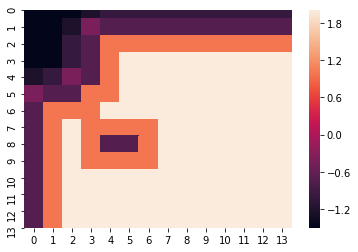

In [28]:
sns.heatmap(calc_dist_map(data_y[365]))

#np.mean(calc_dist_map(z))

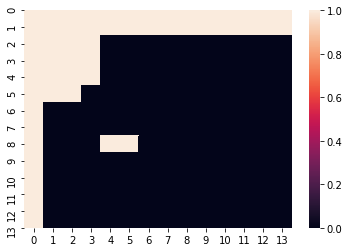

In [29]:
sns.heatmap(data_y[365])


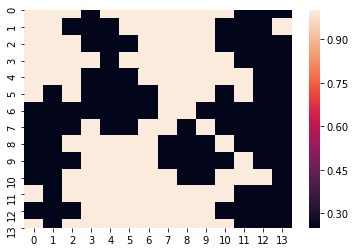

In [30]:
sns.heatmap(calc_mask_map(data_y[222]))

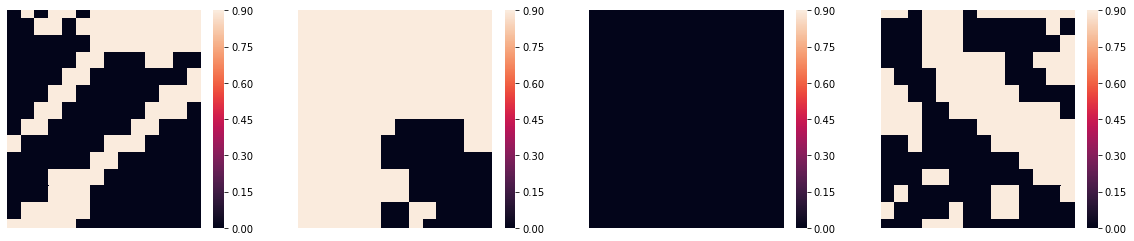

In [31]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[4:8]]])




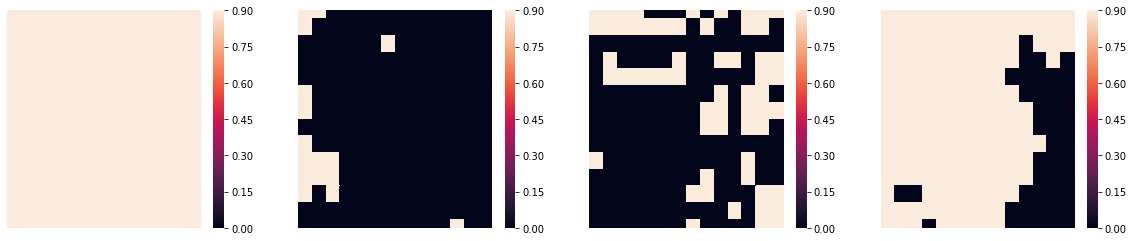

In [32]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[8:12]]])

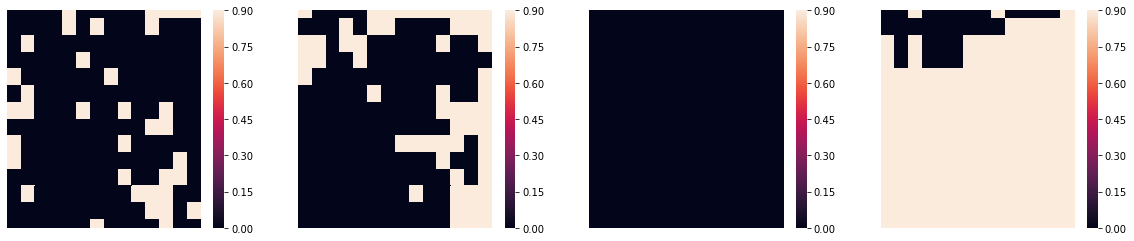

In [33]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[0:4]]])

# Graph set up

In [34]:
FRESH_START = True
best_val = 0.7

START_EPOCH = 1
END_EPOCH = 150
LEARNING_RATE = 3e-3
test_ids = [x for x in range(0, len(test_x))]

print("The model does not overfit after 100 epochs from 5e-4 to 1e-1")
print("We still need to figure out whether or not to use lovasz for finetune")
print("Starting model with: \n {} zone out \n {} l2 \n {} initial LR \n {} final LR \n {} parameters"
     .format(ZONE_OUT_PROB, L2_REG, INITIAL_LR, FINAL_LR, total_parameters))

if not FRESH_START:
    print("Resuming training with a best validation score of {}".format(best_val))
    
if FRESH_START:
    print("Restarting training from scratch on {} "
          "train and {} test samples, total {}".format(len(train_ids), len(test_ids), len(train_ids)/4))

    #optimizer = tf.train.AdamOptimizer(LEARNING_RATE, epsilon = 1e-8)
    optimizer = AdaBoundOptimizer(5e-5, 5e-3)
    # With alpha = 0.8, surf == 0.07, lovasz == 0.12
    train_loss = bce_surf(tf.reshape(labels, (-1, 14, 14, 1)), fm, alpha = alpha)
    #bce_loss = bce_loss(tf.reshape(labels, (-1, 14, 14, 1)), fm, smooth = 0.05, mask = None):
    #l2_loss = tf.losses.get_regularization_l05oss()
    #train_loss += l2_loss

    ft_optimizer = tf.train.GradientDescentOptimizer(ft_lr)
    ft_loss = finetune_loss(tf.reshape(labels, (-1, 14, 14, 1)), fm)
    
    test_loss = bce_surf(tf.reshape(labels, (-1, 14, 14, 1)), fm, alpha = alpha)
    #test_loss = weighted_bce_loss(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = 1.)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)   
        ft_op = ft_optimizer.minimize(train_loss)
        
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 50)
    
print("The graph has been finalized")

The model does not overfit after 100 epochs from 5e-4 to 1e-1
We still need to figure out whether or not to use lovasz for finetune
Starting model with: 
 0.2 zone out 
 0.0 l2 
 0.0002 initial LR 
 0.001 final LR 
 221947 parameters
Restarting training from scratch on 2872 train and 542 test samples, total 718.0
()
The graph has been finalized


In [98]:
# This cell should be run to do fine-tuning, if commented - train from scratch

path = '../models/march-2/42-65-9/'
new_saver = tf.train.import_meta_graph(path + 'model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(path))

INFO:tensorflow:Restoring parameters from ../models/march-2/42-65-9/model


In [70]:
train_losses = []
test_losses = []
dices = []

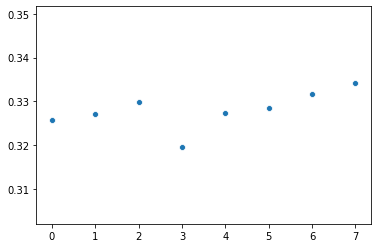

In [199]:
sns.scatterplot(y = np.array(test_losses[0:]),
                x = np.array([x for x in range(len(test_losses[0:]))]))

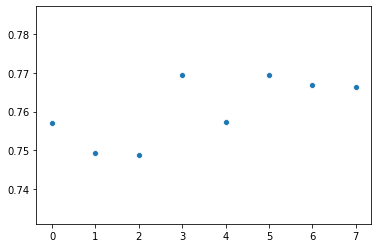

In [198]:
sns.scatterplot(y = np.array(dices[0:]),
                x = np.array([x for x in range(len(dices[0:]))]))

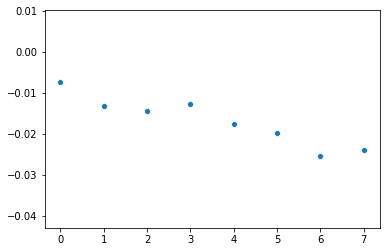

In [200]:
sns.scatterplot(y = np.array(train_losses[:]),
                x = np.array([x for x in range(len(train_losses[:]))]))


In [74]:
from time import sleep

In [197]:
# from time import sleep
import scipy
best_val = 0.496

# Finetune - 0.075 lv_surface for West Africa (minus ghana)
# Finetune - 
train_ids = [x for x in range(len(train_y))]
print("CHECK THE TRAIN / FINETUNING PARAMETER")
for i in range(1, 55):
    #al = np.min([0.05 +(i*0.015), 0.75])
    #al = 0.
    #al = np.min([(0.1 + i*0.025), 0.65])
    al = 0.75
    #al = 0.4
    print(al)
    randomize = equibatch(train_ids)

    op = ft_op
    loss = train_loss
    BATCH_SIZE = 20
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    
    for k in tnrange(int(len(randomize) // BATCH_SIZE)):
        if k % 20 == 0:
            sleep(5)
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        batch_y = train_y[batch_ids, :, :].reshape(len(batch_ids), 14, 14)
        opt, tr = sess.run([op, loss],
                              feed_dict={inp: train_x[batch_ids, :, :, :],
                                         length: train_l[batch_ids].reshape((-1, 1)),
                                         labels: batch_y,
                                         is_training: True,
                                         keep_rate: 0.6,
                                         #keep_rate: np.max((0.98 - (i*0.02), 0.7)),
                                         alpha: al,
                                         ft_lr: 5e-4,
                                         })
        losses.append(tr)
    
    print("Epoch {}: Loss {}".format(i, np.around(np.mean(losses[:-1]), 3)))
    calculate_metrics('ethiopia')
    #calculate_metrics('ghana', al = 0.25)
    #calculate_metrics('kenya')
    val_loss, dice = calculate_metrics('lac', al = 0.25)
    #calculate_metrics('india')
    #calculate_metrics('africaeast')
    #calculate_metrics('africawest', al = al)
    #calculate_metrics('cameroon', al = al)
    _, _ = calculate_metrics('all', al = al)
    train_losses.append(np.mean(losses[:-1]))
    test_losses.append(val_loss)
    dices.append(dice)
    if dice > (best_val - 0.03):
        print("Saving model with {}".format(dice))
        os.mkdir("../models/march-2/lac/new-{}-{}-{}/".format(str(i), str(dice*100)[:2], str(dice*100)[3]))
        save_path = saver.save(sess, "../models/march-2/lac/new-{}-{}-{}/model".format(str(i), str(dice*100)[:2], str(dice*100)[3]))
        if dice > best_val:
            best_val = dice

CHECK THE TRAIN / FINETUNING PARAMETER
0.75
[304, 480, 284, 284, 232, 308, 228, 216, 464]



Epoch 1: Loss -0.013000000268220901
ethiopia: Val loss: 0.2280000001192093 Thresh: 0.5 F1: 0.793 R: 0.812 P: 0.775 D: 0.684 H: 0.912 Error: 0.045
lac: Val loss: 0.3190000057220459 Thresh: 0.5 F1: 0.852 R: 0.848 P: 0.857 D: 0.769 H: 1.307 Error: 0.011
all: Val loss: 0.017999999225139618 Thresh: 0.35 F1: 0.805 R: 0.808 P: 0.803 D: 0.66 H: 0.949 Error: 0.006
Saving model with 0.7694735879566559
0.75
[304, 480, 284, 284, 232, 308, 228, 216, 464]



Epoch 2: Loss -0.017999999225139618
ethiopia: Val loss: 0.23199999332427979 Thresh: 0.35 F1: 0.792 R: 0.769 P: 0.816 D: 0.69 H: 0.901 Error: 0.062
lac: Val loss: 0.3269999921321869 Thresh: 0.45 F1: 0.848 R: 0.84 P: 0.857 D: 0.757 H: 1.311 Error: 0.02
all: Val loss: 0.020999999716877937 Thresh: 0.35 F1: 0.8 R: 0.82 P: 0.781 D: 0.658 H: 0.942 Error: 0.048
Saving model with 0.7572790275229272
0.75
[304, 480, 284, 284, 232, 308, 228, 216, 464]



Epoch 3: Loss -0.019999999552965164
ethiopia: Val loss: 0.2240000069141388 Thresh: 0.35 F1: 0.81 R: 0.786 P: 0.834 D: 0.7 H: 0.891 Error: 0.061
lac: Val loss: 0.328000009059906 Thresh: 0.5 F1: 0.854 R: 0.849 P: 0.858 D: 0.769 H: 1.3 Error: 0.012
all: Val loss: 0.014999999664723873 Thresh: 0.35 F1: 0.807 R: 0.814 P: 0.8 D: 0.661 H: 0.936 Error: 0.017
Saving model with 0.7694587818547018
0.75
[304, 480, 284, 284, 232, 308, 228, 216, 464]



Epoch 4: Loss -0.02500000037252903
ethiopia: Val loss: 0.22499999403953552 Thresh: 0.55 F1: 0.806 R: 0.847 P: 0.769 D: 0.681 H: 0.887 Error: 0.093
lac: Val loss: 0.3319999873638153 Thresh: 0.5 F1: 0.852 R: 0.851 P: 0.852 D: 0.767 H: 1.307 Error: 0.001
all: Val loss: 0.01600000075995922 Thresh: 0.35 F1: 0.806 R: 0.818 P: 0.794 D: 0.66 H: 0.935 Error: 0.029
Saving model with 0.766984092391137
0.75
[304, 480, 284, 284, 232, 308, 228, 216, 464]



Epoch 5: Loss -0.024000000208616257
ethiopia: Val loss: 0.22499999403953552 Thresh: 0.55 F1: 0.813 R: 0.848 P: 0.78 D: 0.682 H: 0.868 Error: 0.08
lac: Val loss: 0.33399999141693115 Thresh: 0.5 F1: 0.854 R: 0.85 P: 0.858 D: 0.766 H: 1.287 Error: 0.009
all: Val loss: 0.014999999664723873 Thresh: 0.35 F1: 0.808 R: 0.82 P: 0.796 D: 0.657 H: 0.919 Error: 0.03
Saving model with 0.7664345612856728
0.75
[304, 480, 284, 284, 232, 308, 228, 216, 464]



Epoch 6: Loss -0.026000000536441803
ethiopia: Val loss: 0.22599999606609344 Thresh: 0.55 F1: 0.818 R: 0.848 P: 0.789 D: 0.683 H: 0.858 Error: 0.069


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/john.brandt/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-197-9fb697589c0c>", line 45, in <module>
    val_loss, dice = calculate_metrics('lac', al = 0.25)
  File "<ipython-input-27-ca7ec3b91d16>", line 146, in calculate_metrics
    alpha: al,
  File "/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 929, in run
    run_metadata_ptr)
  File "/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1152, in _run
    feed_dict_tensor, options, run_metadata)
  File "/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1328, in _do_run
    run_metadata)
  File "/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6

KeyboardInterrupt: 

In [93]:
calculate_metrics('lac', al = 0.25)

lac: Val loss: 0.4569999873638153 Thresh: 0.6 F1: 0.849 R: 0.842 P: 0.855 D: 0.737 H: 1.378 Error: 0.015


(0.4573142, 0.7367461875768253)

In [92]:
i = 5
dice = 0.615
os.mkdir("../models/march-2/{}-{}-{}/".format(str(i), str(dice*100)[:2], str(dice*100)[3]))
save_path = saver.save(sess, "../models/march-2/{}-{}-{}/model"
                       .format(str(i), str(dice*100)[:2], str(dice*100)[3]))

In [196]:
# This is for documentation purposes, leave for now
import scipy
al = 0.25
calculate_metrics('ethiopia', al = al) #0.81 -> 0.818, 0.695 -> 0.711
calculate_metrics('ghana', al = al)
calculate_metrics('kenya', al = al) # 0.798, 0.724 -> 0.806, 0.739
calculate_metrics('lac', al = al) # 0.85, 0.768 -> 0.855, 0.782
calculate_metrics('india', al = al) # 0.76 -> 0.766
calculate_metrics('africaeast', al = al)
calculate_metrics('africawest', al = al)
calculate_metrics('cameroon', al = al)
val_loss, dice = calculate_metrics('all', al = al) # 0.804, 0.639 -> 0.808, 0.645

ethiopia: Val loss: 0.2939999997615814 Thresh: 0.6 F1: 0.818 R: 0.801 P: 0.836 D: 0.711 H: 0.971 Error: 0.044
ghana: Val loss: 0.2930000126361847 Thresh: 0.55 F1: 0.805 R: 0.84 P: 0.773 D: 0.545 H: 0.98 Error: 0.079
kenya: Val loss: 0.29499998688697815 Thresh: 0.5 F1: 0.806 R: 0.771 P: 0.844 D: 0.739 H: 0.953 Error: 0.094
lac: Val loss: 0.35499998927116394 Thresh: 0.6 F1: 0.855 R: 0.807 P: 0.908 D: 0.782 H: 1.291 Error: 0.125
india: Val loss: 0.32899999618530273 Thresh: 0.6 F1: 0.766 R: 0.817 P: 0.722 D: 0.53 H: 0.859 Error: 0.117
africaeast: Val loss: 0.2029999941587448 Thresh: 0.45 F1: 0.922 R: 0.922 P: 0.921 D: 0.743 H: 0.637 Error: 0.001
africawest: Val loss: 0.29899999499320984 Thresh: 0.55 F1: 0.82 R: 0.847 P: 0.796 D: 0.576 H: 1.06 Error: 0.06
cameroon: Val loss: 0.2770000100135803 Thresh: 0.55 F1: 0.509 R: 0.451 P: 0.586 D: 0.616 H: 0.858 Error: 0.3
all: Val loss: 0.30000001192092896 Thresh: 0.6 F1: 0.819 R: 0.82 P: 0.818 D: 0.665 H: 0.994 Error: 0.003


# Model validation and sanity checks





In [91]:
countries

{'africaeast': [0, 34],
 'africawest': [35, 96],
 'cameroon': [97, 135],
 'ethiopia': [136, 248],
 'ghana': [249, 318],
 'india': [319, 369],
 'kenya': [370, 458],
 'lac': [459, 541],
 'all': [0, 541]}

In [201]:
start = 459
test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    ''
    'Plot multipleheatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show



In [202]:
def identify_alignment(true, pred, wsize = 3, difference = 0.2):
    n_single_trees = 0
    for x in range(1, true.shape[0] - 1, 1):
        for y in range(1, true.shape[1] - 1, 1):
            wind_true = true[x-1:x+2, y-1:y+2]
            wind_pred = pred[x-1:x+2, y-1:y+2]
            if wind_true[1, 1] == 1:
                if np.sum(wind_true) == 1:
                    n_single_trees += 1
                    pred_place = np.argmax(wind_pred.flatten())
                    diff = wind_pred.flatten()[pred_place] - wind_pred.flatten()[4]
                    if pred_place != 4:
                        if diff > difference:
                            x_lv = pred_place // 3
                            y_lv = pred_place % 3
                            print(x_lv, y_lv)
                            proposed = wind_true[x_lv - 1:x_lv+2, y_lv-1:y_lv+2]
                            if np.sum(proposed) == 0:
                                print("There is a missed position at {} x, {} y: {}".format(x, y, diff))

In [203]:
matrix_ids = [501, 251, 303, 316, 28, 51, 57, 60] # 89, 160, 168, 215
#to_check = [64, 73, 164, 198, 202, 215, 216, 229, 234]
#to_check = [376, 377, 380, 386, 394, 412, 414, 423, 430, 433, 436, 440, 447, 456]
to_check = [465, 467, 468, 477, 484, 487, 491, 501, 507, 514, 516, 421, 534, 538]

0.9797047970479705
531 0.932
532 0.995
533 0.876
534 0.736
535 1.0
536 0.747
537 0.847
538 0.388
2 0
There is a missed position at 3 x, 7 y: 0.2931916415691376


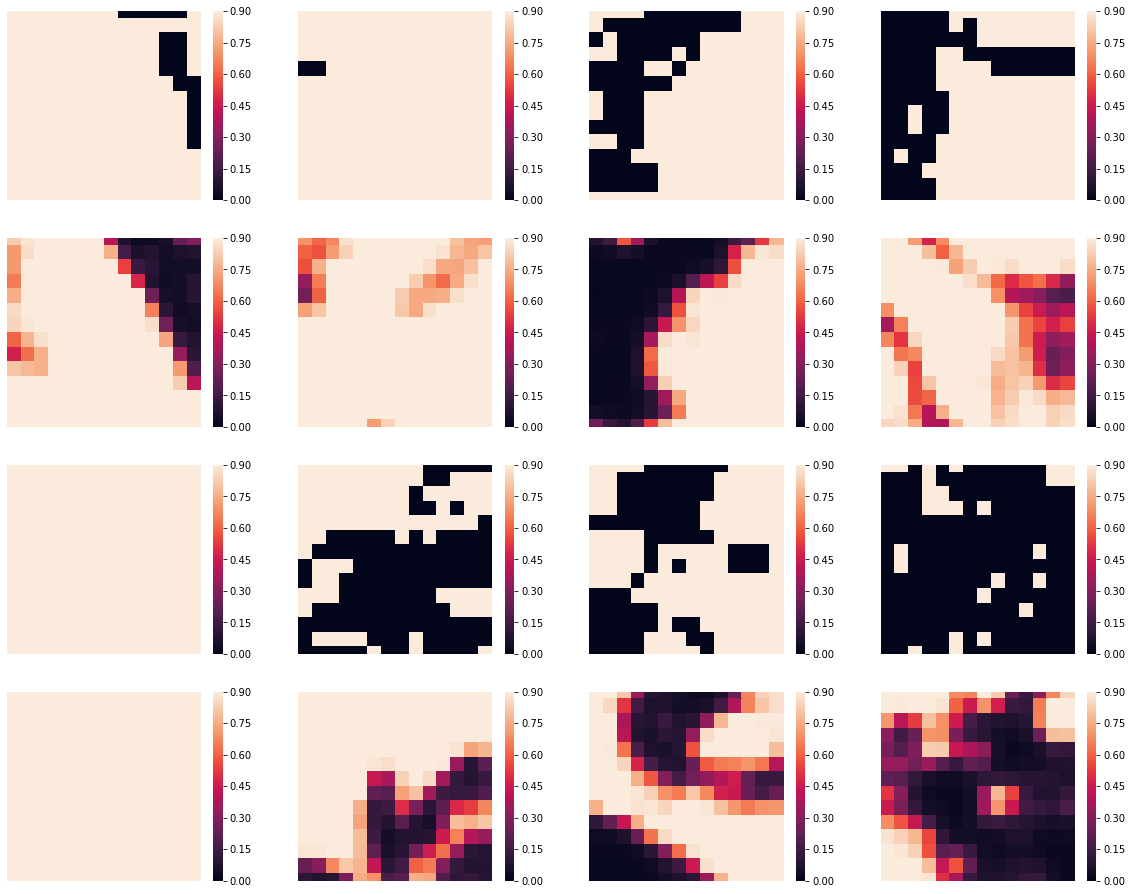

In [213]:
print(start/len(test_ids))
test_ids = sorted(test_ids)
#matrix_ids = to_check[6:]
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
#matrix_ids = to_check[6:]
preds = []
trues = []
for i in matrix_ids:
    idx = i
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: test_lengths[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    y2 = np.copy(y)
    y2[np.where(y2 > 0.5)] = 1.0
    y2[np.where(y2 < 0.5)] = 0.
    dc = np.around(dice_loss(test_y[idx].flatten(), y2.flatten()), 3)
    print(i, dc)
    true = test_y[idx].reshape(14, 14)
    identify_alignment(true, y)
    trues.append(true)
    
    
""


to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]

multiplot(to_plot, nrows = 4, ncols = 4)
# 448
start = start + 8

In [147]:
train_ids = [x for x in range(train_x.shape[0])]
start = 3424*4

3478
13912
13916
13920
13924
13928
13932
13936
13940
13944


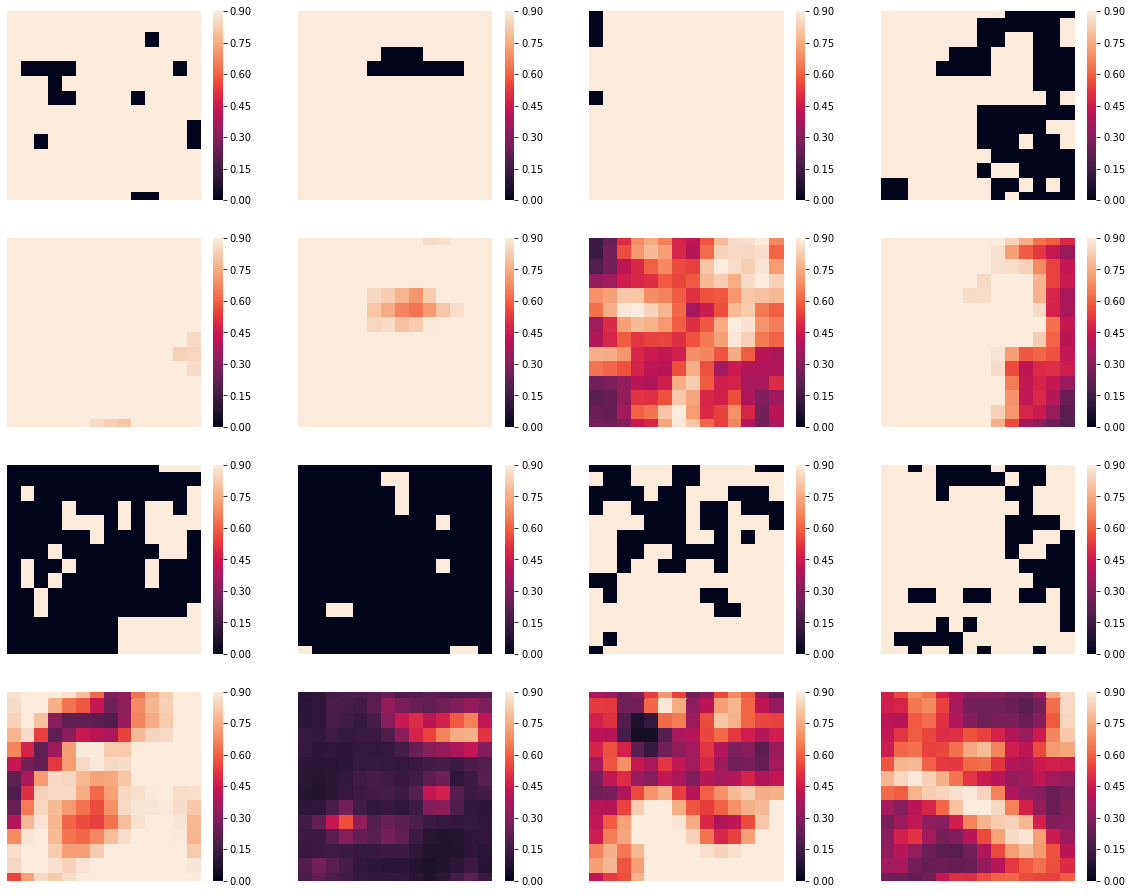

In [154]:
#start = 487*4
# 127, 143, 238, 241, 242, 252, 264, 282, 288, 318
train_ids = sorted(train_ids)
#atrix_ids = random.sample(755, 4)
matrix_ids = [train_ids[start], train_ids[start + 4], train_ids[start + 8], train_ids[start + 12], train_ids[start + 16],
             train_ids[start + 20], train_ids[start + 24], train_ids[start + 28], train_ids[start + 32]]

#matrix_ids = to_id[:9] * 4
#matrix_ids = [722*4, 751*4, 761*4, 762*4]
#matrix_ids = [len(train_x)-28]

preds = []
trues = []
print(start//4)
for i in matrix_ids:
    idx = i
    print(idx)
    y = sess.run([fm], feed_dict={inp: train_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: train_l[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    #y[np.where(y > 0.3)] = 0.85
    preds.append(y)
    true = train_y[idx].reshape(14, 14)
    #identify_alignment(true, y)
    trues.append(true)
    
start += 36
# 20, 
    

to_plot = trues[0:4] + preds[0:4] + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 4, ncols = 4)  

## TODO @jombrandt top 100 worst training, test samples by IOU 


In [58]:
## The idea here is for both training and test, to identify the top 10% of data, by .csv and PLOT-ID
## In terms of binary cross-entropy, so that it can be validated on CEO with DG imagery

tr_ls = []
for i in range(len(train_x)):
    if i % 4 == 0:
        print(i)
        y, losses = sess.run([fm, train_loss], feed_dict={inp: train_x[i].reshape((1, 24, 16, 16, n_bands)),
                                             length: train_l[i].reshape((-1, 1)),
                                             labels: train_y[i].reshape((1, 14, 14)),
                                             is_training: False,
                                             keep_rate: 0.8,
                                             #keep_rate: np.max((0.97 - (i*0.01), 0.85)),
                                             alpha: 1.0,
                                             ft_lr: 0.004,
                                             })
        y = np.array(y).reshape(14, 14)
        #y[np.where(y > 0.7)] = 0.85
        preds.append(y)
        true = train_y[i].reshape(14, 14)
        identify_alignment(true, y, difference = 0.4)
        tr_ls.append(losses)

0
4
8
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
0 0
There is a missed position at 3 x, 7 y: 0.6913198828697205
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200
204
208
212
216
220
224
228
232
236
240
244
248
252
256
260
264
268
272
276
280
284
288
292
296
300
304
308
312
316
320
324
328
332
336
340
344
348
352
356
360
364
368
372
376
380
384
388
392
396
400
404
408
412
416
420
424
428
432
436
440
444
448
452
456
460
464
468
472
476
480
484
488
492
496
500
504
508
512
516
520
524
528
532
536
1 2
540
544
548
552
556
560
564
568
572
576
580
584
588
592
596
0 2
There is a missed position at 12 x, 11 y: 0.5858817100524902
600
604
608
612
616
620
624
628
632
636
640
644
648
652
656
660
664
668
672
676
680
684
688
692
696
700
704
708
712
0 0
There is a missed position at 1 x, 7 y: 0.42168694734573364
716
720
724
728
732
736
740
744
748
752
756
760
764
768
772
776
780
784
788
792
796
800
804
808
812
816
820
0 2
Ther

KeyboardInterrupt: 

In [ ]:
to_id = np.argwhere(np.array(tr_ls) > np.percentile(tr_ls, 98))

In [351]:
# Boundary
to_id.flatten()

array([272, 282, 322, 346, 388, 459, 475, 481, 509, 518, 578, 583, 640,
       650, 665])

In [280]:
# BCE
to_id.flatten()

array([ 63, 272, 315, 322, 337, 346, 388, 412, 459, 474, 475, 481, 486,
       498, 509, 533, 541, 578, 583, 584, 640, 642, 644, 650, 665, 667,
       676, 682, 709])